In [1]:
pip install wandb weave scikit-learn numpy

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ---------------------------------------- 0.0/22.2 MB ? eta -:--:--
   --- ------------------------------------ 2.1/22.2 MB 10.7 MB/s eta 0:00:02
   --------- ------------------------------ 5.2/22.2 MB 12.7 MB/s eta 0:00:02
   ---------------- ----------------------- 9.2/22.2 MB 15.0 MB/s eta 0:00:01
   ------------------------- -------------- 13.9/22.2 MB 16.5 MB/s eta 0:00:01
   ---------------------------------- ----- 19.1/22.2 MB 18.0 MB/s eta 0:00:01
   ---------------------------------------  22.0/22.2 MB 18.6 MB/s eta 0:00:01
   ---------------------------------------- 22.2/22.2 MB 15.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/788.5 kB ? eta -:--:--
   ---------------------------------------- 788.5/788.5 kB 8.

  DEPRECATION: Building 'intervaltree' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'intervaltree'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Win11\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [47]:
# Import the libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import wandb
import weave
import matplotlib.pyplot as plt



In [46]:
# Set the random seed for reproducibility
rng=np.random.RandomState(42)

print(rng.random(5))


[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]


In [88]:
# Generate normal data points around two cluster centers
num_normals=300
normals_cluster1=rng.normal(loc=[0,0], scale=1.0, size=(num_normals//2,2))
normals_cluster2=rng.normal(loc=[5,5], scale=1.0, size=(num_normals//2,2))
X_normals=np.vstack([normals_cluster1, normals_cluster2])


df=pd.DataFrame(X_normals)

In [89]:
df

,0,1
0,-1.592483,1.319422
1,1.191931,-0.302753
2,0.350575,-0.150470
3,0.520599,-1.024950
4,-1.167519,0.810864
...,...,...
295,5.777182,3.930336
296,4.218186,5.121319
297,4.632071,3.891218
298,5.531925,4.427713


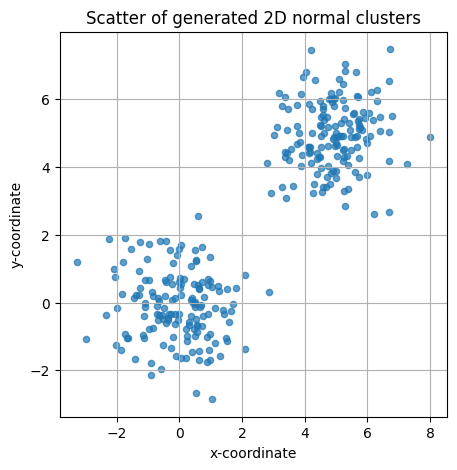

In [70]:
#  View the above random data using the MatplotLib

plt.figure(figsize=(5,5))
plt.scatter(X_normals[:, 0], X_normals[:, 1], s=20, alpha=0.7)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Scatter of generated 2D normal clusters')
plt.grid(True)
plt.show()

In [73]:
# Generate anomalous data points far from the normal clusters
num_anomalies=10
X_anomalies=rng.uniform( low=10, high= 14, size =(num_anomalies, 2))
df=pd.DataFrame(X_anomalies)
df

,0,1
0,10.289394,13.514123
1,11.207339,12.601188
2,11.316023,11.565817
3,11.048452,11.372176
4,11.642802,12.881664
5,12.046145,13.774261
6,10.167522,12.012273
7,12.336899,13.680788
8,10.196634,12.293998
9,13.414520,10.967711


In [ ]:
#  Combine the normal and anomaly data into one dataset
X=np.vstack([X_normals, X_anomalies])
# Create labels for evaluation(0=normal, 1= anomaly)
y=np.hstack([np.zeros(X_normals.shape[0]),np.ones(X_anomalies.shape[0])])

print("Total sample: ", X.shape[0])
print("Normal Samples: ", X_normals.shape[0])
print("Anomalous samples: ", X_anomalies.shape[0])

Total sample:  310
Normal Samples:  300
Anomalous samples:  10


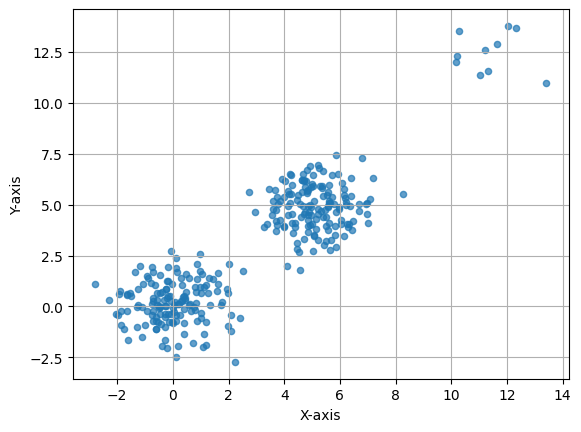

In [90]:
# plt.figure(figsize=(5,5))
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.scatter(X[:,0],X[:,1], s=20,alpha=0.7)
plt.grid(True)
plt.show()

In [91]:
# Configure and Train the Isolation forest model
model= IsolationForest(contamination=0.04, random_state=42)
model.fit(X)

# Use the trained model to predict anomalies on the dataset
# The model.predict method returns 1 for normal, -1 for anomaly for each sample
predictions=model.predict(X)
# Convert predictions to binary 0/1 (1 for anomaly) for easier interpretation
y_pred=(predictions==-1).astype(int)

print("Anomalies flagged by model: ", y_pred.sum())

Anomalies flagged by model:  13


In [93]:
# Big question: We have explicitely provided 10 anomaly but the model predict the 12-13 anomaly. The model doesn't know the true numbers. Out of these predicted value how many are actual anomaly and predicted the negative positive data or misclassified.

# Let's evaluate the models performance.

# Calculate performance metrics
true_anomalies=(y==1)
predicted_anomalies=(y_pred==1)

# True +ve (TP): model flagged anomaly and it was actually anomaly
TP=np.sum(predicted_anomalies & true_anomalies)

# False positives (FP): model flagged anomaly but it was actually normal
FP=np.sum(predicted_anomalies & ~true_anomalies)

# False negative (FN): model said normal but it was actually anomaly
FN=np.sum((~predicted_anomalies) & true_anomalies)

# True Negatives (TN): model said normal and it was actually normal
TN=np.sum((~predicted_anomalies)& ~true_anomalies)

# Compute precision and recall
precision =TP/(TP+FP) if (TP+FP)>0 else 0.0
recall= TP/(TP+FN) if (TP+FN)>0 else 0.0

print(f"True anomalies detected (TP): {TP}/{np.sum(true_anomalies)}")
print(f"False psoitivies (FP) - normal mislabeled as anomaly: {FP}")
print(f"False negatives (FN) -anomalies missed:{FN}")
print(f"Recall: {recall:.2f}")

True anomalies detected (TP): 10/10
False psoitivies (FP) - normal mislabeled as anomaly: 3
False negatives (FN) -anomalies missed:0
Recall: 1.00
